# PESU IO PROJECT

Import modules:

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil

Load Dataset:

In [16]:
import kagglehub
import os

datasetpath = kagglehub.dataset_download("datamunge/sign-language-mnist")
path = datasetpath

Using Colab cache for faster access to the 'sign-language-mnist' dataset.


Data Preparation:

In [17]:
# Preprocessing and visualizing data
train_data = pd.read_csv(os.path.join(path, 'sign_mnist_train.csv'))
test_data = pd.read_csv(os.path.join(path, 'sign_mnist_test.csv'))

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

# Display some sample images
def display_samples(data, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img = data.iloc[i, 1:].values.reshape(28, 28)
        label = data.iloc[i, 0]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

Training data shape: (27455, 785)
Testing data shape: (7172, 785)


Train a CNN using Pytorch:

Epoch [1/24], Loss: 1.0816
Accuracy on test set after epoch 1: 82.10%
Epoch [2/24], Loss: 0.1267
Accuracy on test set after epoch 2: 85.57%
Epoch [3/24], Loss: 0.0195
Accuracy on test set after epoch 3: 88.66%
Epoch [4/24], Loss: 0.0054
Accuracy on test set after epoch 4: 90.00%
Epoch [5/24], Loss: 0.0023
Accuracy on test set after epoch 5: 89.78%
Epoch [6/24], Loss: 0.0396
Accuracy on test set after epoch 6: 90.18%
Epoch [7/24], Loss: 0.0015
Accuracy on test set after epoch 7: 90.45%
Epoch [8/24], Loss: 0.0025
Accuracy on test set after epoch 8: 90.85%
Epoch [9/24], Loss: 0.0004
Accuracy on test set after epoch 9: 90.77%
Epoch [10/24], Loss: 0.0003
Accuracy on test set after epoch 10: 90.62%
Epoch [11/24], Loss: 0.0002
Accuracy on test set after epoch 11: 90.67%
Epoch [12/24], Loss: 0.0002
Accuracy on test set after epoch 12: 90.45%
Epoch [13/24], Loss: 0.0001
Accuracy on test set after epoch 13: 90.77%
Epoch [14/24], Loss: 0.0150
Accuracy on test set after epoch 14: 80.76%
Epoch [15/

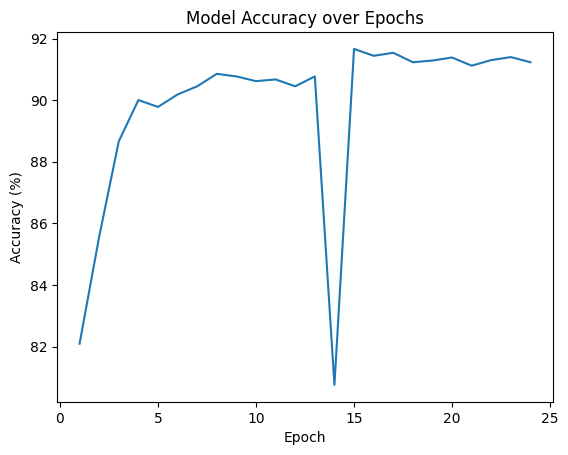

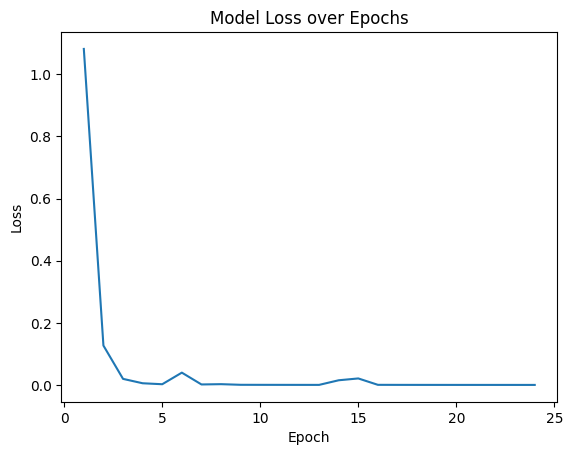

In [18]:
# Train a CNN using Pytorch
class SignLanguageDataset(Dataset):
    def __init__(self, data):
        self.labels = data.iloc[:, 0].values
        self.images = data.iloc[:, 1:].values.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx]), torch.tensor(self.labels[idx])

train_dataset = SignLanguageDataset(train_data)
test_dataset = SignLanguageDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 26)  # 26 classes for A-Z

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 24
accuracy_list = []
loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Accuracy calculation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on test set after epoch {epoch+1}: {100 * correct / total:.2f}%')
    accuracy_list.append(100 * correct / total)
    loss_list.append(running_loss / len(train_loader))

# Plot accuracy over epochs
plt.plot(range(1, num_epochs + 1), accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy over Epochs')
plt.show()

# Plot loss over epochs
plt.plot(range(1, num_epochs + 1), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss over Epochs')
plt.show()

Evaluate the model using per-class accuracy:

In [20]:
# Evaluate the model using per-class accuracy:
class_correct = [0] * 26
class_total = [0] * 26

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(26):
    if class_total[i] > 0:
        print(f'Accuracy of class {i}: {100 * class_correct[i] / class_total[i]:.2f}%')
    else:
        print(f'Accuracy of class {i}: N/A (no samples)')

Accuracy of class 0: 100.00%
Accuracy of class 1: 99.77%
Accuracy of class 2: 91.94%
Accuracy of class 3: 100.00%
Accuracy of class 4: 100.00%
Accuracy of class 5: 100.00%
Accuracy of class 6: 85.63%
Accuracy of class 7: 91.51%
Accuracy of class 8: 92.71%
Accuracy of class 9: N/A (no samples)
Accuracy of class 10: 93.66%
Accuracy of class 11: 100.00%
Accuracy of class 12: 89.09%
Accuracy of class 13: 85.57%
Accuracy of class 14: 79.67%
Accuracy of class 15: 94.81%
Accuracy of class 16: 100.00%
Accuracy of class 17: 70.14%
Accuracy of class 18: 91.46%
Accuracy of class 19: 65.73%
Accuracy of class 20: 85.34%
Accuracy of class 21: 88.44%
Accuracy of class 22: 91.26%
Accuracy of class 23: 86.52%
Accuracy of class 24: 88.25%
Accuracy of class 25: N/A (no samples)


Test the model on sample input images:

In [21]:
# Testing the model on sample inputs:

import PIL.Image as Image
import torchvision.transforms as Transforms

transform = Transforms.Compose([
    Transforms.Grayscale(),
    Transforms.Resize((28, 28)),
    Transforms.ToTensor(),
    Transforms.Normalize((0.5,), (0.5,))
])

def predict_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

print("Predicted class for image:", predict_image(os.path.join(path, 'amer_sign2.png')))
print("Predicted sign:", chr(predict_image(os.path.join(path, 'amer_sign2.png')) + 65))  # Convert to A-Z

Predicted class for image: 22
Predicted sign: W
